# Fine-Tuning OpenAI Models for Retrieval Augmented Generation (RAG) with Qdrant and Few-Shot Learning

The aim of this notebook is to walk through a comprehensive example of how to fine-tune OpenAI models for Retrieval Augmented Generation (RAG). 

We will also be integrating Qdrant and Few-Shot Learning to boost the model's performance and reduce hallucinations. This could serve as a practical guide for ML practitioners, data scientists, and AI Engineers interested in leveraging the power of OpenAI models for specific use-cases. 🤩

## Why should you read this blog?

You want to learn how to 
- [Fine-tune OpenAI models](https://platform.openai.com/docs/guides/fine-tuning/) for specific use-cases
- Use [Qdrant](https://qdrant.tech/documentation/) to improve the performance of your RAG model
- Use fine-tuning to improve the correctness of your RAG model and reduce hallucinations

To begin, we've selected a dataset where we've a guarantee that the retrieval is perfect. We've selected a subset of the [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) dataset, which is a collection of questions and answers about Wikipedia articles. We've also included samples where the answer is not present in the context, to demonstrate how RAG handles this case.

## Table of Contents
1. Setting up the Environment

### Section A: Zero-Shot Learning
2. Data Preparation: SQuADv2 Dataset
3. Answering using Base gpt-3.5-turbo-0613 model
4. Fine-tuning and Answering using Fine-tuned model
5. **Evaluation**: How well does the model perform?

### Section B: Few-Shot Learning
5. Using Qdrant to Improve RAG Prompt
6. Fine-Tuning OpenAI Model with Qdrant
7. Comparison and Results

## 1. Setting Up the Environment

### Install and Import Dependencies

In [76]:
# !pip install pandas openai tqdm tenacity scikit-learn tiktoken python-dotenv seaborn --upgrade --quiet

In [2]:
import json
import os
import time

import pandas as pd
import openai
import tiktoken
import seaborn as sns
from tenacity import retry, wait_exponential
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


tqdm.pandas()

## Section A

## 2. Data Preparation: SQuADv2 Data Subsets

For the purpose of demonstration, we'll make small slices from the train and validation splits of the [SQuADv2](https://rajpurkar.github.io/SQuAD-explorer/) dataset. This dataset has questions and contexts where the answer is not present in the context, to help us evaluate how LLM handles this case.

We'll read the data from the JSON files and create a dataframe with the following columns: `question`, `context`, `answer`, `is_impossible`.

### Download the Data

In [6]:
!mkdir -p local_cache
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O local_cache/train.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O local_cache/dev.json

--2023-09-08 16:40:51--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘local_cache/train.json’

local_cache/train.j 100%[===================>]  40.17M  36.1MB/s    in 1.1s    

2023-09-08 16:40:55 (36.1 MB/s) - ‘local_cache/train.json’ saved [42123633/42123633]

--2023-09-08 16:40:55--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘local_cache/dev.json’


### Read JSON to DataFrame

In [7]:
def json_to_dataframe_with_titles(json_data):
    qas = []
    context = []
    is_impossible = []
    answers = []
    titles = []

    for article in json_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                qas.append(qa['question'].strip())
                context.append(paragraph['context'])
                is_impossible.append(qa['is_impossible'])
                
                ans_list = []
                for ans in qa['answers']:
                    ans_list.append(ans['text'])
                answers.append(ans_list)
                titles.append(title)

    df = pd.DataFrame({'title': titles, 'question': qas, 'context': context, 'is_impossible': is_impossible, 'answers': answers})
    return df

def get_diverse_sample(df, sample_size=100, random_state=42):
    sample_df = df.groupby(['title', 'is_impossible']).apply(lambda x: x.sample(min(len(x), max(1, sample_size // 50)), random_state=random_state)).reset_index(drop=True)
    
    if len(sample_df) < sample_size:
        remaining_sample_size = sample_size - len(sample_df)
        remaining_df = df.drop(sample_df.index).sample(remaining_sample_size, random_state=random_state)
        sample_df = pd.concat([sample_df, remaining_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return sample_df.sample(min(sample_size, len(sample_df)), random_state=random_state).reset_index(drop=True)

train_df = json_to_dataframe_with_titles(json.load(open('local_cache/train.json')))
val_df = json_to_dataframe_with_titles(json.load(open('local_cache/dev.json')))

df = get_diverse_sample(val_df, sample_size=100, random_state=42)

## 3. Answering using Base gpt-3.5-turbo-0613 model

### 3.1 Zero Shot Prompt

In [8]:
# Function to get prompt messages
def get_prompt(row):
    return [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
    Question: {row.question}\n\n
    Context: {row.context}\n\n
    Answer:\n""",
        },
    ]

### 3.2 Answering using Zero Shot Prompt

In [11]:
# Function with tenacity for retries
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
    return openai.ChatCompletion.create(
        model=model,
        messages=messages,
        stop=["\n\n"],
        max_tokens=100,
        temperature=0.0,
    )


# Main function to answer question
def answer_question(row, prompt_func=get_prompt, model="gpt-3.5-turbo-0613"):
    messages = prompt_func(row)
    response = api_call(messages, model)
    return response["choices"][0]["message"]["content"]

⏰ **Time to run: ~3 min**

In [12]:
# Use progress_apply with tqdm for progress bar
df["generated_answer"] = df.progress_apply(answer_question, axis=1)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


In [13]:
df.to_json("local_cache/100_val.json", orient="records", lines=True)

## 4. Fine-tuning and Answering using Fine-tuned model

For the complete fine-tuning process, please refer to the [OpenAI Fine-Tuning Docs](https://platform.openai.com/docs/guides/fine-tuning/use-a-fine-tuned-model).

### 4.1 Prepare the Fine-Tuning Data

We need to prepare the data for fine-tuning. We'll use a few samples from train split of same dataset as before, but we'll add the answer to the context. This will help the model learn to retrieve the answer from the context.

In [14]:
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        answer = row["answers"][0] if row["answers"] else "I don't know"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n""",
            },
            {"role": "assistant", "content": answer},
        ]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

with open("local_cache/100_train.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

100%|██████████| 100/100 [00:00<00:00, 65659.11it/s]


**Tip: 💡 Verify the Fine-Tuning Data**

You can see this [cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/Chat_finetuning_data_prep.ipynb) for more details on how to prepare the data for fine-tuning.

### 4.2 Fine-Tune OpenAI Model

If you're new to OpenAI Model Fine-Tuning, please refer to the [How to finetune Chat models](https://github.com/openai/openai-cookbook/blob/448a0595b84ced3bebc9a1568b625e748f9c1d60/examples/How_to_finetune_chat_models.ipynb) notebook. You can also refer to the [OpenAI Fine-Tuning Docs](platform.openai.com/docs/guides/fine-tuning/use-a-fine-tuned-model) for more details.

In [15]:
class OpenAIFineTuner:
    def __init__(self, training_file_path, model_name, suffix):
        self.training_file_path = training_file_path
        self.model_name = model_name
        self.suffix = suffix
        self.file_object = None
        self.fine_tuning_job = None
        self.model_id = None

    def create_openai_file(self):
        self.file_object = openai.File.create(
            file=open(self.training_file_path, "r"),
            purpose="fine-tune",
        )

    def wait_for_file_processing(self, sleep_time=20):
        while self.file_object.status != 'processed':
            time.sleep(sleep_time)
            self.file_object.refresh()
            print("File Status: ", self.file_object.status)

    def create_fine_tuning_job(self):
        self.fine_tuning_job = openai.FineTuningJob.create(
            training_file=self.file_object["id"],
            model=self.model_name,
            suffix=self.suffix,
        )

    def wait_for_fine_tuning(self, sleep_time=45):
        while self.fine_tuning_job.status != 'succeeded':
            time.sleep(sleep_time)
            self.fine_tuning_job.refresh()
            print("Job Status: ", self.fine_tuning_job.status)

    def retrieve_fine_tuned_model(self):
        self.model_id = openai.FineTuningJob.retrieve(self.fine_tuning_job["id"]).fine_tuned_model
        return self.model_id

    def fine_tune_model(self):
        self.create_openai_file()
        self.wait_for_file_processing()
        self.create_fine_tuning_job()
        self.wait_for_fine_tuning()
        return self.retrieve_fine_tuned_model()

fine_tuner = OpenAIFineTuner(
        training_file_path="local_cache/100_train.jsonl",
        model_name="gpt-3.5-turbo",
        suffix="100trn20230907"
    )

⏰ **Time to run: ~10-20 minutes**

In [16]:
model_id = fine_tuner.fine_tune_model()
model_id

File Status:  uploaded
File Status:  processed
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  succeeded


'ft:gpt-3.5-turbo-0613:qdrant:100trn20230907:7wU85Xwb'

#### 4.2.1 Try out the Fine-Tuned Model

In [17]:
completion = openai.ChatCompletion.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"},
        {"role": "assistant", "content": "Hi, how can I help you today?"},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
    ],
)

print(completion.choices[0].message)

{
  "role": "assistant",
  "content": "I don't know"
}


### 4.3 Answer Using the Fine-Tuned Model

⏰ **Time to run: ~5 min**

In [18]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_id, axis=1)

100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


## 5. Evaluation: How well does the model perform?

To evaluate the model's performance, compare the predicted answer to the actual answers -- if any of the actual answers are present in the predicted answer, then it's a match. We've also created error categories to help you understand where the model is struggling.

When we know that a correct answer exists in the context, we can measure the model's performance, there are 3 possible outcomes:

1. ✅ **Answered Correctly**: The model responsded the correct answer. It may have also included other answers that were not in the context.
2. ❎ **Skipped**: The model responded with "I don't know" (IDK) while the answer was present in the context. It's better than giving the wrong answer. It's better for the model say "I don't know" than giving the wrong answer. In our design, we know that a true answer exists and hence we're able to measure it -- this is not always the case. *This is a model error*. We exclude this from the overall error rate. 
3. ❌ **Wrong**: The model responded with an incorrect answer. **This is a model ERROR.**

When we know that a correct answer does not exist in the context, we can measure the model's performance, there are 2 possible outcomes:

4. ❌ **Hallucination**: The model responded with an answer, when "I don't know" was expected. **This is a model ERROR.** 
5. ✅ **I don't know**: The model responded with "I don't know" (IDK) and the answer was not present in the context. **This is a model WIN.**

In [30]:
class ConfusionMatrixEvaluator:
    def __init__(self, df, answers_column="generated_answer"):
        self.df = df
        self.y_pred = []
        self.labels = [
            "✅ Answered Correctly",
            "❎ Skipped",
            "❌ Wrong Answer", 
            "❌ Hallucination", 
            "✅ I don't know"
        ]
        self.answers_column = answers_column

    def _evaluate_single_row(self, row):
        is_impossible = row["is_impossible"]
        generated_answer = row[self.answers_column].lower()
        actual_answers = [ans.lower() for ans in row["answers"]]

        y_pred = (
            "✅ Answered Correctly"
            if not is_impossible
            and any(ans in generated_answer for ans in actual_answers)
            else "❎ Skipped"
            if not is_impossible and generated_answer == "i don't know"
            else "❌ Wrong Answer"
            if not is_impossible and generated_answer not in actual_answers
            else "❌ Hallucination"
            if is_impossible and generated_answer != "i don't know"
            else "✅ I don't know"
        )
        return y_pred

    def evaluate_answers(self):
        self.y_pred = self.df.apply(self._evaluate_single_row, axis=1)

    def generate_matrices(self, use_percentages=False):
        # Using value_counts to create a Series of frequencies, then reindexing to include missing labels with count 0
        freq_series = self.y_pred.value_counts().reindex(self.labels, fill_value=0)
        if use_percentages:
            total = freq_series.sum()
            freq_series = (freq_series / total * 100).apply("{0:.2f}%".format)
        return freq_series


def evaluate_model(df, answers_column):
    """
    Evaluate the confusion matrix for a given DataFrame and answer column.
    """
    evaluator = ConfusionMatrixEvaluator(df, answers_column=answers_column)
    evaluator.evaluate_answers()
    error_categories = evaluator.generate_matrices(use_percentages=True)
    return error_categories

In [31]:
evaluate_model(df, "generated_answer")

✅ Answered Correctly    44.00%
❎ Skipped                0.00%
❌ Wrong Answer           9.00%
❌ Hallucination         47.00%
✅ I don't know           0.00%
Name: count, dtype: object

In [32]:
evaluate_model(df, "ft_generated_answer")

✅ Answered Correctly    32.00%
❎ Skipped               18.00%
❌ Wrong Answer           3.00%
❌ Hallucination          7.00%
✅ I don't know          40.00%
Name: count, dtype: object

In [33]:
# Optionally, save the results to a JSON file
df.to_json("local_cache/100_val_ft.json", orient="records", lines=True)

In [34]:
df = pd.read_json("local_cache/100_val_ft.json", orient="records", lines=True)

### Plotting the Results

/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


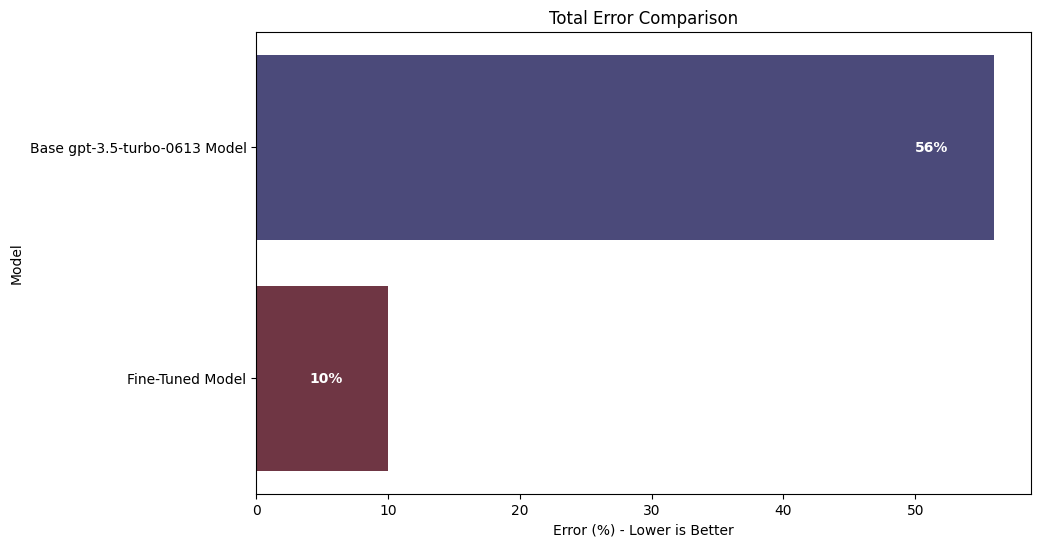

In [36]:
def plot_overall_error(df, answer_columns, labels):
    error_categories = ["❌ Hallucination", "❌ Wrong Answer"]
    
    # Prepare data for Seaborn
    data = []
    for i, col in enumerate(answer_columns):
        results = evaluate_model(df, col)
        matrix_error = sum([float(results.loc[cat].replace("%", "")) for cat in error_categories])
        data.append([labels[i], matrix_error])

    df_plot = pd.DataFrame(data, columns=["Model", "Overall Error"])
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Overall Error", y="Model", data=df_plot, palette="icefire")
    
    # Add annotations
    for i, p in enumerate(ax.patches):
        ax.text(p.get_width() - 6, p.get_y() + p.get_height() / 2, f"{p.get_width():.0f}%", 
                va='center', color='white', fontweight='bold')

    plt.xlabel("Error (%) - Lower is Better")
    plt.title("Total Error Comparison")
    plt.show()

# Plot only the overall error
plot_overall_error(df, answer_columns=["generated_answer", "ft_generated_answer"], labels=["Base gpt-3.5-turbo-0613 Model", "Fine-Tuned Model"])

/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

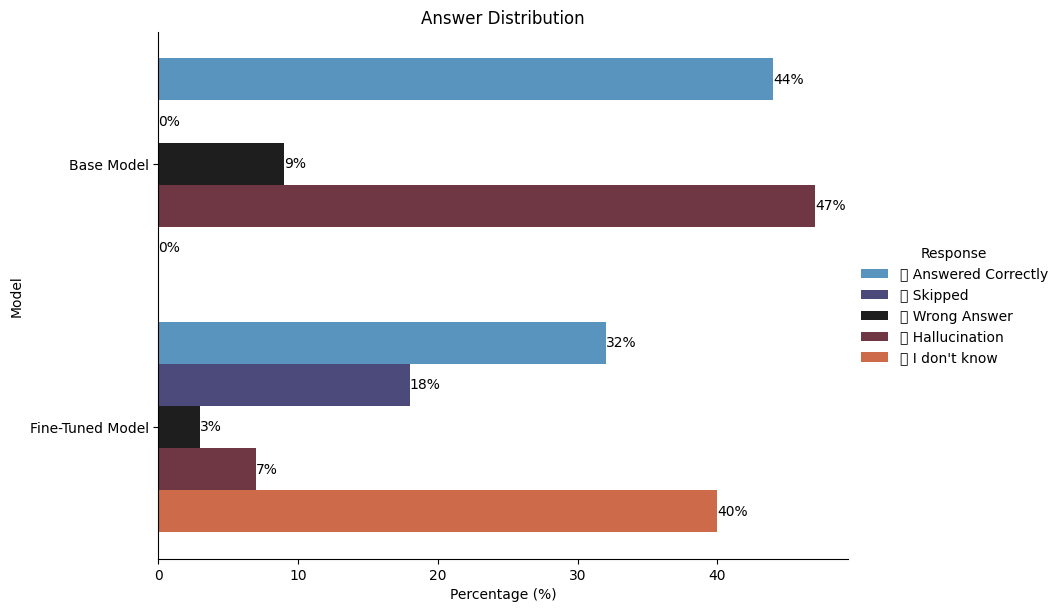

In [51]:
def plot_correctness(df, answer_columns, labels):
    error_categories = [
            "✅ Answered Correctly",
            "❎ Skipped",
            "❌ Wrong Answer", 
            "❌ Hallucination", 
            "✅ I don't know"
        ]
    annotations = [
            "✅ Answered Correctly",
            "❎ Skipped",
            "❌ Wrong Answer", 
            "❌ Hallucination", 
            "✅ I don't know"
        ]
    cat_map = dict(zip(error_categories, annotations)) 
    # Prepare data for Seaborn
    data = []
    for i, col in enumerate(answer_columns):
        results = evaluate_model(df, col)
        for category in error_categories:
            matrix_error = float(results.loc[category].replace("%", ""))
            data.append([labels[i], cat_map[category], matrix_error])

    df_plot = pd.DataFrame(data, columns=["Model", "Response", "Percentage"])
    
    # Create the plot
    g = sns.catplot(x="Percentage", y="Model", hue="Response", data=df_plot, kind="bar", height=6, aspect=1.5, palette="icefire")
    
    ax = g.facet_axis(0, 0)
    
    # Add annotations
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_width():.0f}%", (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="left", va="center")
    plt.xlabel("Percentage (%)")
    plt.title("Answer Distribution")
    plt.show()

plot_correctness(df, answer_columns=["generated_answer", "ft_generated_answer"], labels=["Base Model", "Fine-Tuned Model"])

### Observations

1. The fine-tuned model is better at saying "I don't know"
2. Hallucinations drop from 47% to 7% with fine-tuning
3. Wrong answers drop from 9% to 3% with fine-tuning

**Correct answers also drop from 44% to 32% with fine-tuning** - this is because the fine-tuned model is **more conservative** and says "I don't know" more often. This is a good thing because it's better to say "I don't know" than to give a wrong answer.

That said, we want to improve the correctness of the model, even if that increases the hallucinations. We'll use Qdrant and Few-Shot Learning to achieve this.

# Section B: Few Shot Learning


We'll select a few examples from the dataset, including cases where the answer is not present in the context. We'll then use these examples to create a prompt that we can use to fine-tune the model. We'll then measure the performance of the fine-tuned model.

## 5. Fine-Tuning OpenAI Model with Qdrant

So far, we've been using the OpenAI model to answer questions without using examples of the answer. The previous step made it work better on in-context examples, while this one helps it generalize to unseen data, and attempt to learn when to say "I don't know" and when to give an answer.

This is where few-shot learning comes in!

Few-shot learning is a type of transfer learning that allows us to answer questions where the answer is not present in the context. We can do this by providing a few examples of the answer we're looking for, and the model will learn to answer questions where the answer is not present in the context.

### 5.1 Embed the Training Data

Embeddings are a way to represent sentences as an array of floats. We'll use the embeddings to find the most similar questions to the ones we're looking for.

In [38]:
# !pip install fastembed

In [39]:
import os
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

Now that we've the Qdrant imports in place, 

In [40]:
qdrant_client = QdrantClient(
    url=os.getenv("QDRANT_URL"), api_key=os.getenv("QDRANT_API_KEY"), timeout=6000, prefer_grpc=True
)

collection_name = "squadv2-cookbook"

# # Create the collection
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=384, distance=Distance.COSINE),
# )

In [41]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

100%|██████████| 77.7M/77.7M [00:07<00:00, 10.9MiB/s]


### 5.3 Embedding the Questions

We embed the entire training set questions. We'll use the question to question similarity to find the most similar questions to the question we're looking for. This is a workflow which is used in RAG to leverage the OpenAI model ability of incontext learning with more examples. This is what we call Few Shot Learning here.

**❗️⏰ Important Note: This step can take upto 3 hours to complete. Please be patient. If you see Out of Memory errors or Kernel Crashes, please reduce the batch size to 32, restart the kernel and run the notebook again. This code needs to be run only ONCE.**

In [42]:
# def generate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
#     batch_size = 512
#     questions = df["question"].tolist()
#     total_batches = len(questions) // batch_size + 1
    
#     pbar = tqdm(total=len(questions), desc="Generating embeddings")
    
#     # Generate embeddings in batches to improve performance
#     embeddings = []
#     for i in range(total_batches):
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, len(questions))
#         batch = questions[start_idx:end_idx]
        
#         batch_embeddings = embedding_model.embed(batch, batch_size=batch_size)
#         embeddings.extend(batch_embeddings)
#         pbar.update(len(batch))
        
#     pbar.close()
    
#     # Convert embeddings to list of lists
#     embeddings_list = [embedding.tolist() for embedding in embeddings]
    
#     # Create a temporary DataFrame to hold the embeddings and existing DataFrame columns
#     temp_df = df.copy()
#     temp_df["embeddings"] = embeddings_list
#     temp_df["id"] = temp_df.index
    
#     # Generate PointStruct objects using DataFrame apply method
#     points = temp_df.progress_apply(
#         lambda row: PointStruct(
#             id=row["id"],
#             vector=row["embeddings"],
#             payload={
#                 "question": row["question"],
#                 "title": row["title"],
#                 "context": row["context"],
#                 "is_impossible": row["is_impossible"],
#                 "answers": row["answers"],
#             },
#         ),
#         axis=1,
#     ).tolist()

#     return points

# points = generate_points_from_dataframe(train_df)

#### Upload the Embeddings to Qdrant

Note that configuring Qdrant is outside the scope of this notebook. Please refer to the [Qdrant](https://qdrant.tech) for more information. We used a timeout of 600 seconds for the upload, and grpc compression to speed up the upload.

In [43]:
# operation_info = qdrant_client.upsert(
#     collection_name=collection_name, wait=True, points=points
# )
# print(operation_info)

## 6. Using Qdrant to Improve RAG Prompt

Now that we've uploaded the embeddings to Qdrant, we can use Qdrant to find the most similar questions to the question we're looking for. We'll use the top 5 most similar questions to create a prompt that we can use to fine-tune the model. We'll then measure the performance of the fine-tuned model on the same validation set, but with few shot prompting!

Our main function `get_few_shot_prompt` serves as the workhorse for generating prompts for few-shot learning. It does this by retrieving similar questions from Qdrant - a vector search engine, using an embeddings model. Here is the high-level workflow:

1. Retrieve similar questions from Qdrant where the **answer is present** in the context
2. Retrieve similar questions from Qdrant where the **answer is IMPOSSIBLE** i.e. the expected answer is "I don't know" to find in the context
3. Create a prompt using the retrieved questions
4. Fine-tune the model using the prompt
5. Evaluate the fine-tuned model on the validation set with the same prompting technique

In [84]:
def get_few_shot_prompt(row):

    query, row_context = row["question"], row["context"]

    embeddings = list(embedding_model.embed([query]))
    query_embedding = embeddings[0].tolist()

    num_of_qa_to_retrieve = 5

    # Query Qdrant for similar questions that have an answer
    q1 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        with_payload=True,
        limit=num_of_qa_to_retrieve,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=False,
                    ),
                ),
            ],
        )
    )

    # Query Qdrant for similar questions that are IMPOSSIBLE to answer
    q2 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=True,
                    ),
                ),
            ]
        ),
        with_payload=True,
        limit=num_of_qa_to_retrieve,
    )


    instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""
    # If there is a next best question, add it to the prompt
    
    def q_to_prompt(q):
        question, context = q.payload["question"], q.payload["context"]
        answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"
        return [
            {
                "role": "user", 
                "content": f"""Question: {question}\n\nContext: {context}\n\nAnswer:"""
            },
            {"role": "assistant", "content": answer},
        ]

    rag_prompt = []
    
    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[1])
    if len(q2) >= 1:
        rag_prompt += q_to_prompt(q2[1])
    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[2])
    
    

    rag_prompt += [
        {
            "role": "user",
            "content": f"""Question: {query}\n\nContext: {row_context}\n\nAnswer:"""
        },
    ]

    rag_prompt = [{"role": "system", "content": instruction}] + rag_prompt
    return rag_prompt

In [85]:
# ⏰ Time: 2 min
train_sample["few_shot_prompt"] = train_sample.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

## 6. Fine-Tuning OpenAI Model with Qdrant

### Upload the Fine-Tuning Data to OpenAI

In [86]:
# Prepare the OpenAI File format i.e. JSONL from train_sample
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        messages = row["few_shot_prompt"]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

with open("local_cache/100_train_few_shot.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

  0%|          | 0/100 [00:00<?, ?it/s]

⏰ **Time to run: ~15-30 minutes**

In [87]:
fine_tuner = OpenAIFineTuner(
        training_file_path="local_cache/100_train_few_shot.jsonl",
        model_name="gpt-3.5-turbo",
        suffix="trnfewshot20230907"
    )

model_id = fine_tuner.fine_tune_model()
model_id

File Status:  uploaded
File Status:  uploaded
File Status:  processed
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  succeeded


'ft:gpt-3.5-turbo-0613:qdrant:trnfewshot20230907:7wWa4owB'

In [88]:
# Let's try this out
completion = openai.ChatCompletion.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
        {
            "role": "assistant",
            "content": "I don't know",
        },
        {
            "role": "user",
            "content": "Question: Where did Maharana Pratap die?\n\nContext: Rana Pratap's defiance of the mighty Mughal empire, almost alone and unaided by the other Rajput states, constitute a glorious saga of Rajput valour and the spirit of self sacrifice for cherished principles. Rana Pratap's methods of guerrilla warfare was later elaborated further by Malik Ambar, the Deccani general, and by Emperor Shivaji.\nAnswer:",
        },
        {
            "role": "assistant",
            "content": "I don't know",
        },
        {
            "role": "user",
            "content": "Question: Who did Rana Pratap fight against?\n\nContext: In stark contrast to other Rajput rulers who accommodated and formed alliances with the various Muslim dynasties in the subcontinent, by the time Pratap ascended to the throne, Mewar was going through a long standing conflict with the Mughals which started with the defeat of his grandfather Rana Sanga in the Battle of Khanwa in 1527 and continued with the defeat of his father Udai Singh II in Siege of Chittorgarh in 1568. Pratap Singh, gained distinction for his refusal to form any political alliance with the Mughal Empire and his resistance to Muslim domination. The conflicts between Pratap Singh and Akbar led to the Battle of Haldighati. Answer:",
        },
        {
            "role": "assistant",
            "content": "Akbar",
        },
        {
            "role": "user",
            "content": "Question: Which state is Chittorgarh in?\n\nContext: Chittorgarh, located in the southern part of the state of Rajasthan, 233 km (144.8 mi) from Ajmer, midway between Delhi and Mumbai on the National Highway 8 (India) in the road network of Golden Quadrilateral. Chittorgarh is situated where National Highways No. 76 & 79 intersect. Answer:",
        },
    ],
)
print("Correct Answer: Rajasthan\nModel Answer:")
print(completion.choices[0].message)

Correct Answer: Rajasthan
Model Answer:
{
  "role": "assistant",
  "content": "Rajasthan"
}


⏰ **Time to run: 5-15 min**

In [89]:
df["ft_generated_answer_few_shot"] = df.progress_apply(answer_question, model=model_id, prompt_func=get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [90]:
df.to_json("local_cache/100_val_ft_few_shot.json", orient="records", lines=True)

## 7. Comparison and Results

In [91]:
evaluate_model(df, "ft_generated_answer_few_shot")

✅ Answered Correctly    44.00%
❎ Skipped                5.00%
❌ Wrong Answer           4.00%
❌ Hallucination         25.00%
✅ I don't know          22.00%
Name: count, dtype: object

/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/fst/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

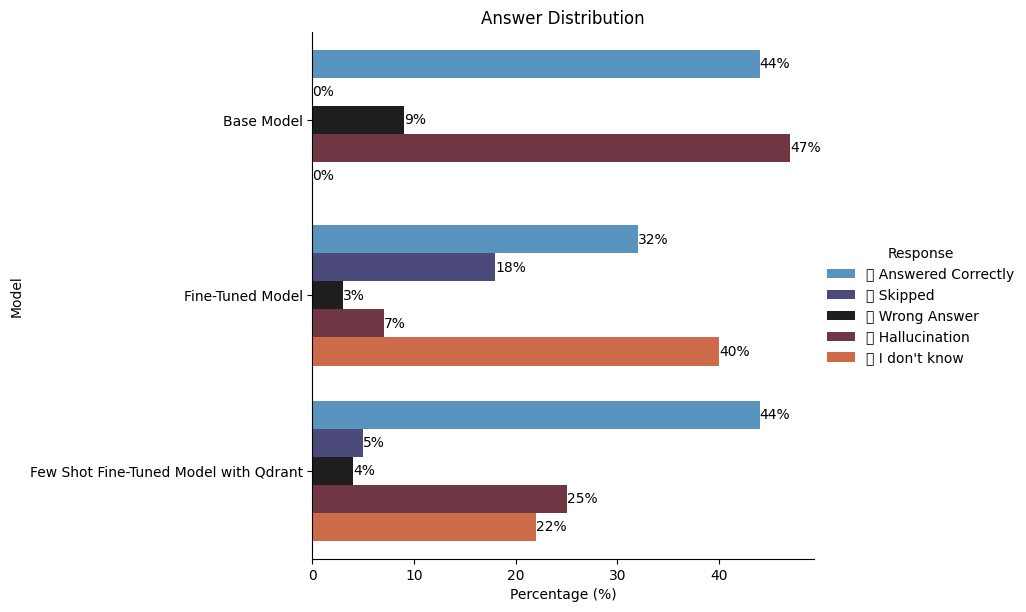

In [92]:
plot_correctness(df, answer_columns=["generated_answer", "ft_generated_answer", "ft_generated_answer_few_shot"], labels=["Base Model", "Fine-Tuned Model", "Few Shot Fine-Tuned Model with Qdrant"])

### Results

Category | Base | Fine-Tuned | Fine-Tuned with Qdrant |
| --- | --- | --- | --- |
| Correct | 44% | 32% | 44% |
| Skipped | 0% | 18% | 5% |
| Wrong | 9% | 3% | 4% |
| Hallucination | 47% | 7% | 25% |
| I don't know | 0% | 40% | 22% |

### Observations

#### Compared to base model
1. The few shot fine-tuned with Qdrant model is as good as the base model at answering questions where the answer is present in the context. 44% of the questions are answered correctly in both cases.
2. The few shot fine-tuned with Qdrant model is better at saying "I don't know" when the answer is not present in the context. 22% of the questions are answered with "I don't know" vs 0% for the base model.
3. The few shot fine-tuned with Qdrant model is better at reducing hallucinations. 25% of the questions are answered with hallucinations vs 47% for the base model.


#### Compared to fine-tuned model
1. The few shot fine-tuned with Qdrant model gets more correct answers than the fine-tuned model: **44% of the questions are answered correctly vs 32%** for the fine-tuned model
2. The few shot fine-tuned with Qdrant model is better at deciding when to say "I don't know" when the answer is not present in the context. **22% of the questions are answered with "I don't know" vs 40%** for the fine-tuned model.

Few Shot Fine-Tuning with Qdrant is a great way to control and steer the performance of your RAG system. 

Here, we made the model less conservative and more confident by using Qdrant to find similar questions. 

One can also use Qdrant to make the model more conservative. We did this by giving examples of questions where the answer is not present in the context. 
This is biasing the model to say "I don't know" more often. 

Similarly, one can also use Qdrant to make the model more confident by giving examples of questions where the answer is present in the context. 
This biases the model to give an answer more often. 